In this notebook we will be training a convolutional LSTM (CNN+LSTM) model. Please use the table of contents on the left panel to navigate between sections.<br>

Performance summary;
The CNN+LSTM model showed a test accuracy of 23.56%, an AUROC score of 0.624, and an F1 score of 0.227.

In [ ]:
# import

import sys
import os
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, Conv1D, LeakyReLU
from keras.layers import Input, LSTM
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
import keras
from matplotlib.pyplot import figure
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# mount to google drive

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# Load Data

Load data with RNA sequences each containing 4,000 nt:



In [ ]:
X_train=np.load("/gdrive/My Drive/Final_Project/data/X_train.npy")
X_val=np.load("/gdrive/My Drive/Final_Project/data/X_val.npy")
X_test=np.load("/gdrive/My Drive/Final_Project/data/X_test.npy")
y_train=np.load("/gdrive/My Drive/Final_Project/data/y_train.npy")
y_val=np.load("/gdrive/My Drive/Final_Project/data/y_val.npy")
y_test=np.load("/gdrive/My Drive/Final_Project/data/y_test.npy")

In [ ]:
# expand X dimension (2->3)
X_train = np.expand_dims(X_train[:,:-1], axis = 2)
X_val = np.expand_dims(X_val[:,:-1], axis = 2)
X_test = np.expand_dims(X_test[:,:-1], axis = 2)

# Train Model

In [ ]:
def network_CNN_LSTM(X_train,y_train):
    im_shape=(4000,5)
    inputs_cnn_lstm=Input(shape= 
    (im_shape), name='inputs_cnn_lstm')
    
    # Your code
    # conv layer with 32 filters
    conv1=Convolution1D(filters=32, kernel_size=(6), activation='relu')(inputs_cnn_lstm)
    bn1=BatchNormalization()(conv1)
    mp1=MaxPool1D(pool_size=(3,), strides=2, padding='same')(bn1)
    # conv layer with 16 filters
    conv2=Convolution1D(filters=16, kernel_size=(3), activation='relu')(mp1)
    bn2=BatchNormalization()(conv2)
    mp2=MaxPool1D(pool_size=(2,), strides=2, padding='same')(bn2)
    lstm = LSTM(32)(mp2)
    # flatten the output
    flat=Flatten()(lstm)
    # dense layer with 32 neurons
    dense1=Dense(units = 32, activation='relu')(flat)
    # dense layer with 16 neurons
    dense2=Dense(units = 16, activation='relu')(dense1)
    # softmax as last layer with 7 outputs
    main_output=(Dense(units = 7, activation='softmax'))(dense2)
    #

    
    model = Model(inputs=inputs_cnn_lstm, outputs=main_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return(model)

In [ ]:
model=network_CNN_LSTM(X_train,y_train)
print(model.summary())

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_cnn_lstm (InputLayer  [(None, 3999, 1)]        0         
 )                                                               
                                                                 
 conv1d_18 (Conv1D)          (None, 3994, 32)          224       
                                                                 
 batch_normalization_18 (Bat  (None, 3994, 32)         128       
 chNormalization)                                                
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 1997, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 1995, 16)          1552      
                                                           

In [ ]:
history = model.fit(X_train,y_train,epochs=10, batch_size=64, validation_data=(X_val,y_val))

Epoch 1/10
22/22 [==============================] - 20s 929ms/step - loss: 1.3656 - accuracy: 0.4318 - val_loss: 2.0158 - val_accuracy: 0.2701
Epoch 2/10
22/22 [==============================] - 20s 924ms/step - loss: 1.3440 - accuracy: 0.4332 - val_loss: 2.1309 - val_accuracy: 0.2586
Epoch 3/10
22/22 [==============================] - 21s 939ms/step - loss: 1.3224 - accuracy: 0.4619 - val_loss: 2.1898 - val_accuracy: 0.2644
Epoch 4/10
22/22 [==============================] - 20s 932ms/step - loss: 1.2955 - accuracy: 0.4526 - val_loss: 2.2074 - val_accuracy: 0.2184
Epoch 5/10
22/22 [==============================] - 24s 1s/step - loss: 1.3082 - accuracy: 0.4526 - val_loss: 2.1324 - val_accuracy: 0.2471
Epoch 6/10
22/22 [==============================] - 21s 939ms/step - loss: 1.2726 - accuracy: 0.4569 - val_loss: 2.0536 - val_accuracy: 0.3161
Epoch 7/10
22/22 [==============================] - 21s 942ms/step - loss: 1.2447 - accuracy: 0.4684 - val_loss: 2.1187 - val_accuracy: 0.2414
Ep

# Evaluate Model Performance

In [ ]:
# Evaluation function
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['1','2', '3']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

## Accuracy

Accuracy: 23.56%


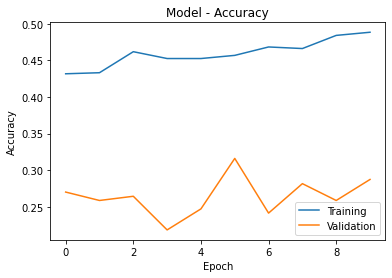

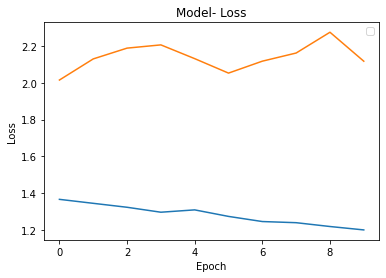

In [ ]:
# plot accuracy and loss
evaluate_model(history, X_test, y_test, model)
y_pred=model.predict(X_test)

## AUCROC Score

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred, multi_class='ovo', average='weighted')

0.624206456857319

In [ ]:
roc_auc_score(y_test_split, y_pred_split, multi_class='ovo', average='weighted')

0.56029019171377

## Confusion Matrix and F1 Score

In [ ]:
# convert the probabilities for each of the 7 classes in y_pred to the class with the highest proba
index = 0
y_pred_ = []

for i in y_pred:
  y_pred_.append(np.argmax(i))
  index+=1

In [ ]:
index = 0
y_pred_split_ = []

for i in y_pred_split:
  y_pred_split_.append(np.argmax(i))
  index+=1

'Cytoplasm' = 0, 'Cytosol' = 1, 'Nucleus' = 2, 'Ribosome' = 3, 'chromatin' = 4, 'nucleolus' = 5, 'nucleoplasm' = 6

The i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class. True values corresponds to the y-axis, prediction corresponds to the x-axis.

In [ ]:
cm = confusion_matrix(y_test, y_pred_)
cm

array([[10,  0,  5,  1,  4,  0,  2],
       [ 1,  7,  3,  4,  4,  1,  2],
       [ 2,  4,  7,  3,  1,  1,  3],
       [ 4,  1,  0, 11,  3,  0,  7],
       [ 4,  1,  3,  3,  5,  1, 13],
       [ 0,  2,  1,  5,  6,  0,  7],
       [ 1,  8,  4,  2, 13,  3,  1]])

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_, average='weighted')

0.226591615243185

# Save Model and History

We will save the models so they can be loaded again later:

In [ ]:
model.save('CNN_LSTM.h5')  # creates a HDF5 file

In [ ]:
# to load:
# from keras.models import load_model
# model_1 = load_model('CNN_LSTM.h5')

Likewise, save history:

In [ ]:
np.save('history_CNN_LSTM.npy', history)

INFO:tensorflow:Assets written to: ram://1a38e444-80fb-4041-8a08-1be186f786cb/assets


INFO:tensorflow:Assets written to: ram://1a38e444-80fb-4041-8a08-1be186f786cb/assets


In [ ]:
# to load:
# history_1=np.load('history_CNN_LSTM.npy',allow_pickle='TRUE').item()